In [77]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
#import cv2
import gc
import matplotlib.pyplot as plt
#import openslide
#from openslide.deepzoom import DeepZoomGenerator
import tifffile as tifi
import sklearn
import tensorflow as tf
import seaborn as sns
from PIL import Image
import random


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,mean_absolute_percentage_error

from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import vgg16, vgg19, resnet50, mobilenet, inception_resnet_v2, densenet, inception_v3, xception, nasnet, ResNet152V2
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, InputLayer, LayerNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam, Adadelta, Adamax
from tensorflow.keras import layers, models, Model
from tensorflow.keras.losses import MeanAbsoluteError, MeanAbsolutePercentageError
from tensorflow.keras.layers import Input, Activation,MaxPooling2D, concatenate

from imblearn.over_sampling import RandomOverSampler

#Models of TINTOlib
from TINTOlib.tinto import TINTO
from TINTOlib.supertml import SuperTML
from TINTOlib.igtd import IGTD
from TINTOlib.refined import REFINED
from TINTOlib.barGraph import BarGraph
from TINTOlib.distanceMatrix import DistanceMatrix
from TINTOlib.combination import Combination

In [78]:
SEED = 64

# SET RANDOM SEED FOR REPRODUCIBILITY
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [79]:
# Create variable to store dataset name
dataset_name = 'california_housing'

In [80]:
#Select the model and the parameters
pixel = 20
problem_type = "regression"
#image_model = REFINED(problem= problem_type,hcIterations=5)
image_model = TINTO(problem= problem_type, blur=True)
#image_model = IGTD(problem= problem_type)
#image_model = BarGraph(problem= problem_type)
#image_model = DistanceMatrix(problem= problem_type)
#image_model = Combination(problem= problem_type)
#image_model = SuperTML(problem= problem_type)

#Define the dataset path and the folder where the images will be saved
dataset_path = "../sample_data/boston.csv"
images_folder = f"../HyNNImages/Regression/images_{dataset_name}_IGTD"

In [81]:
df = pd.read_csv(f"../Datasets_benchmark/{dataset_name}.csv")

In [82]:
import os

# Generate the images if the folder does not exist
if not os.path.exists(images_folder):
    #Generate thet images
    image_model.generateImages(df, images_folder)
else:
    print("The images are already generated")

img_paths = os.path.join(images_folder,problem_type+".csv")

print(img_paths)

The images are already generated
../HyNNImages/Regression/images_california_housing_IGTD\regression.csv


In [83]:
imgs = pd.read_csv(img_paths)

#imgs["images"]= images_folder + "\\" + imgs["images"]
imgs["images"]= images_folder + "/" + imgs["images"]

In [84]:
combined_dataset = pd.concat([imgs,df],axis=1)
#MEDV is the objective value in Boston dataset
df_x = combined_dataset.drop(df.columns[-1],axis=1).drop("values",axis=1)
df_y = combined_dataset["values"]

print(df_y)

0        4.526
1        3.585
2        3.521
3        3.413
4        3.422
         ...  
20635    0.781
20636    0.771
20637    0.923
20638    0.847
20639    0.894
Name: values, Length: 20640, dtype: float64


In [85]:
import cv2
X_train, X_val, y_train, y_val = train_test_split(df_x, df_y, test_size = 0.40, random_state = 123)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.50, random_state = 123)

#TIDY DATA SPLITTED
X_train_num = X_train.drop("images",axis=1)
X_val_num = X_val.drop("images",axis=1)
X_test_num = X_test.drop("images",axis=1)

#IMAGES
# For 3 canal (RGB)
X_train_img = np.array([cv2.imread(img) for img in X_train["images"]])
X_val_img = np.array([cv2.imread(img) for img in X_val["images"]])
X_test_img = np.array([cv2.imread(img) for img in X_test["images"]])

# For 1 canal (GRAY SCALE)
"""X_train_img = np.array([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in X_train["images"]])
X_val_img = np.array([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in X_val["images"]])
X_test_img = np.array([cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in X_test["images"]])"""

attributes = len(X_train_num.columns)
imgs_shape = X_train_img[0].shape

print("Images shape: ",imgs_shape)
print("Attributres: ",attributes)
pixels=X_train_img[0].shape[0]
print("Image size (pixels):", pixels)

Images shape:  (3, 3, 3)
Attributres:  8
Image size (pixels): 3


In [86]:
from sklearn.preprocessing import MinMaxScaler
# Create a MinMaxScaler object
scaler = MinMaxScaler()

In [87]:
# Fit the scaler to the training data and transform it
X_train_num = pd.DataFrame(scaler.fit_transform(X_train_num), columns=X_train_num.columns)

# Transform the validation and testing data using the fitted scaler
X_val_num = pd.DataFrame(scaler.transform(X_val_num), columns=X_val_num.columns)
X_test_num = pd.DataFrame(scaler.transform(X_test_num), columns=X_test_num.columns)

In [88]:
# CNN
# This represents the number of filters or output channels in the convolutional layer.

model = Sequential([
    Input(shape=(3, 3, 3)),
    Conv2D(4, (2, 2), activation='relu'),
    Flatten(),
    Dense(8, activation='relu'),
    Dense(1)  # Output layer for regression
])

In [12]:
# CNN big
model = Sequential([
    Input(shape=(20, 20, 3)),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='linear')
])

In [89]:
import tensorflow.keras.backend as K

def r_square(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    r2 = 1 - SS_res / (SS_tot + K.epsilon())
    return r2

METRICS = [
    tf.keras.metrics.MeanSquaredError(name = 'mse'),
    tf.keras.metrics.MeanAbsoluteError(name = 'mae'),
    tf.keras.metrics.RootMeanSquaredError(name = 'rmse'),
    r_square,
]

In [90]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    min_delta=0.001,     # Minimum change in the monitored quantity to qualify as an improvement
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    verbose=1,           # Print messages when the callback takes an action
    mode='min'           # Training will stop when the quantity monitored has stopped decreasing
)


In [91]:
opt = Adam(learning_rate=1e-3)

In [92]:
model.compile(
    loss="mse",
    optimizer=opt,
    metrics = METRICS
)

In [93]:
X_train_img.shape

(12384, 3, 3, 3)

In [94]:
model_history=model.fit(
    x=X_train_img, y=y_train,
    validation_data=(X_val_img, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/50


387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1704.6501 - mae: 24.8013 - mse: 1704.6501 - r_square: -1338.5930 - rmse: 36.6461 - val_loss: 29.6818 - val_mae: 4.1867 - val_mse: 29.6818 - val_r_square: -23.3550 - val_rmse: 5.4481
Epoch 2/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 25.3906 - mae: 3.8826 - mse: 25.3906 - r_square: -20.5463 - rmse: 5.0353 - val_loss: 18.8695 - val_mae: 3.3280 - val_mse: 18.8695 - val_r_square: -14.4771 - val_rmse: 4.3439
Epoch 3/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.6290 - mae: 3.1559 - mse: 16.6290 - r_square: -13.0796 - rmse: 4.0763 - val_loss: 13.1395 - val_mae: 2.7770 - val_mse: 13.1395 - val_r_square: -9.8028 - val_rmse: 3.6248
Epoch 4/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - loss: 11.1408 - mae: 2.5933 - mse: 11.1408 - r_square: -8.4088 - rmse: 3.3365 - val_loss: 7.3275 - val_mae: 2.0166 - val_mse: 7.3275 - val_r_square: -5.1283 - val_rmse: 2.7069
Epoch 5/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - loss: 5.6568 -

In [95]:
os.makedirs("models/CNN_Regression", exist_ok=True)
model.save(f"models/CNN_Regression/model_{dataset_name}.keras")

In [96]:
print(model_history.history.keys())

dict_keys(['loss', 'mae', 'mse', 'r_square', 'rmse', 'val_loss', 'val_mae', 'val_mse', 'val_r_square', 'val_rmse'])


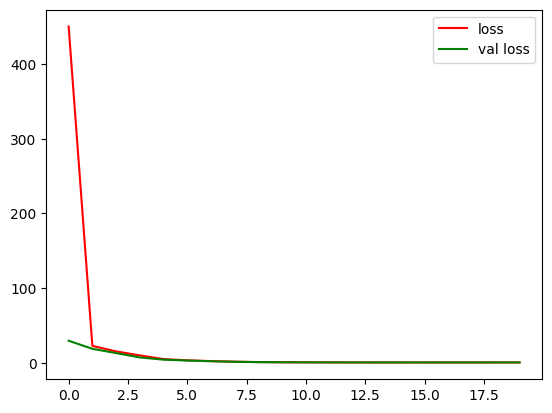

In [97]:
plt.plot(model_history.history['loss'], color = 'red', label = 'loss')
plt.plot(model_history.history['val_loss'], color = 'green', label = 'val loss')
plt.legend(loc = 'upper right')
plt.show()

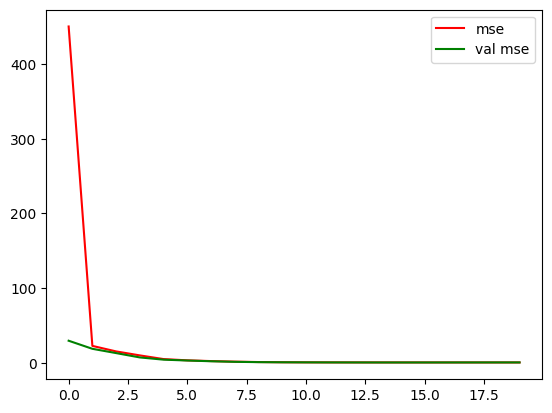

In [98]:
plt.plot(model_history.history['mse'], color = 'red', label = 'mse')
plt.plot(model_history.history['val_mse'], color = 'green', label = 'val mse')
plt.legend(loc = 'upper right')
plt.show()

In [99]:
# Evaluate the model on the training set and collect scores for custom metrics
train_scores = model.evaluate(X_train_img, y_train)

# Evaluate the model on the validation set and collect scores for custom metrics
val_scores = model.evaluate(X_val_img, y_val)

score_test= model.evaluate(X_test_img, y_test)

# Save training and validation scores for custom metrics
metrics = {
    'train_loss': train_scores[0],
    'train_mse': train_scores[1],
    'train_mae': train_scores[2],
    'train_rmse': train_scores[3],
    'train_r2': train_scores[4],
    'val_loss': val_scores[0],
    'val_mse': val_scores[1],
    'val_mae': val_scores[2],
    'val_rmse': val_scores[3],
    'val_r2': val_scores[4],
    'test_loss': score_test[0],
    'test_mse': score_test[1],
    'test_mae': score_test[2],
    'test_rmse': score_test[3],
    'test_r2': score_test[4]
}

147/387 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6369 - mae: 0.6547 - mse: 0.6369 - r_square: 0.4879 - rmse: 0.7980

387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6401 - mae: 0.6518 - mse: 0.6401 - r_square: 0.4808 - rmse: 0.8000 
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6629 - mae: 0.6626 - mse: 0.6629 - r_square: 0.4770 - rmse: 0.8141
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - loss: 0.6139 - mae: 0.6377 - mse: 0.6139 - r_square: 0.4834 - rmse: 0.7832


In [100]:
# Save metrics to a file
os.makedirs('logs/CNN_Regression', exist_ok=True)
with open(f'logs/CNN_Regression/{dataset_name}_metrics.txt', 'w') as f:
    for key, value in metrics.items():
        f.write(f'{key}: {value}\n')